In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import warnings
warnings.filterwarnings(action = 'ignore')

In [151]:
df = pd.read_csv('../Data/spam.csv', encoding= 'latin-1')

In [152]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [153]:
df.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [154]:
df.shape

(5572, 5)

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [156]:
df[~df['Unnamed: 2'].isnull()]['Unnamed: 2']

95                                            PO Box 5249
281      the person is definitely special for u..... B...
444      HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...
671      wanted to say hi. HI!!!\" Stop? Send STOP to ...
710       this wont even start........ Datz confidence.."
899                                           PO Box 5249
1038                                                   GN
1127                                             .;-):-D"
1266    just been in bedbut mite go 2 thepub l8tr if u...
1384     bt not his girlfrnd... G o o d n i g h t . . .@"
1428                                        I'll come up"
1559     don't miss ur best life for anything... Gud n...
1637     just as a shop has to give a guarantee on wha...
1669     But at d end my love compromised me for every...
1675     the toughest is acting Happy with all unspoke...
1936                                  smoke hella weed\""
1937                       \" not \"what i need to do.\""
1997    JUST G

In [157]:
df[~df['Unnamed: 2'].isnull()]['v2'] 

95      Your free ringtone is waiting to be collected....
281                                   \Wen u miss someone
444     \HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...
671            SMS. ac sun0819 posts HELLO:\You seem cool
710     Height of Confidence: All the Aeronautics prof...
899     Your free ringtone is waiting to be collected....
1038    Edison has rightly said, \A fool can ask more ...
1127    Height of \Oh shit....!!\" situation: A guy th...
1266      \Hey sorry I didntgive ya a a bellearlier hunny
1384    Storming msg: Wen u lift d phne, u say \HELLO\...
1428    Tell you what, if you make a little spreadshee...
1559    Single line with a big meaning::::: \Miss anyt...
1637    0A$NETWORKS allow companies to bill for SMS, s...
1669    Very hurting n meaningful lines ever: \I compr...
1675    Painful words- \I thought being Happy was the ...
1936        My planning usually stops at \find hella weed
1937    The fact that you're cleaning shows you know w...
1997          

In [158]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [159]:
df['v2'] = np.where((df['Unnamed: 2'].isnull()), df['v2'], (df['v2'] + ' ' + df['Unnamed: 2']))

In [160]:
df['v2'] = np.where((df['Unnamed: 3'].isnull()), df['v2'], (df['v2'] + ' ' + df['Unnamed: 3']))

In [161]:
df['v2'] = np.where((df['Unnamed: 4'].isnull()), df['v2'], (df['v2'] + ' ' + df['Unnamed: 4']))

In [165]:
df.iloc[95, 1]

'Your free ringtone is waiting to be collected. Simply text the password \\MIX\\" to 85069 to verify. Get Usher and Britney. FML  PO Box 5249  MK17 92H. 450Ppw 16"'

In [162]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [163]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace= True, axis = 1)

In [164]:
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [187]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

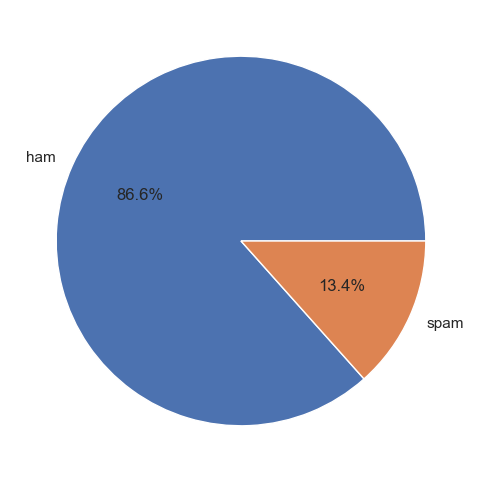

In [191]:
sns.set()
plt.figure(figsize = (6, 6))
plt.pie(x = (df['v1'].value_counts().values), labels= (df['v1'].value_counts().keys()), autopct= '%1.1f%%')
plt.show()

In [200]:
X = df['v2']
y = df['v1']

In [201]:
X

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5572, dtype: object

In [202]:
y

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: v1, Length: 5572, dtype: object

In [203]:
X.shape

(5572,)

In [204]:
y.shape

(5572,)

In [205]:
X = X.values.flatten()

In [206]:
X[1]

'Ok lar... Joking wif u oni...'

In [209]:
print(list( stopwords.words('english')))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [213]:
ps = PorterStemmer()

corpus = []

for i in range(len(X)):
    text = re.sub('[a-zA-Z]', ' ', X[i])
    text = text.lower()
    text = text.split()
    
    text = [ps.stem(j) for j in text if not j in stopwords.words('english')]
    text = ' '.join(text)
    corpus.append(text)
    print(f"Status : {i}")

Status : 0
Status : 1
Status : 2
Status : 3
Status : 4
Status : 5
Status : 6
Status : 7
Status : 8
Status : 9
Status : 10
Status : 11
Status : 12
Status : 13
Status : 14
Status : 15
Status : 16
Status : 17
Status : 18
Status : 19
Status : 20
Status : 21
Status : 22
Status : 23
Status : 24
Status : 25
Status : 26
Status : 27
Status : 28
Status : 29
Status : 30
Status : 31
Status : 32
Status : 33
Status : 34
Status : 35
Status : 36
Status : 37
Status : 38
Status : 39
Status : 40
Status : 41
Status : 42
Status : 43
Status : 44
Status : 45
Status : 46
Status : 47
Status : 48
Status : 49
Status : 50
Status : 51
Status : 52
Status : 53
Status : 54
Status : 55
Status : 56
Status : 57
Status : 58
Status : 59
Status : 60
Status : 61
Status : 62
Status : 63
Status : 64
Status : 65
Status : 66
Status : 67
Status : 68
Status : 69
Status : 70
Status : 71
Status : 72
Status : 73
Status : 74
Status : 75
Status : 76
Status : 77
Status : 78
Status : 79
Status : 80
Status : 81
Status : 82
Status : 83
St

Status : 716
Status : 717
Status : 718
Status : 719
Status : 720
Status : 721
Status : 722
Status : 723
Status : 724
Status : 725
Status : 726
Status : 727
Status : 728
Status : 729
Status : 730
Status : 731
Status : 732
Status : 733
Status : 734
Status : 735
Status : 736
Status : 737
Status : 738
Status : 739
Status : 740
Status : 741
Status : 742
Status : 743
Status : 744
Status : 745
Status : 746
Status : 747
Status : 748
Status : 749
Status : 750
Status : 751
Status : 752
Status : 753
Status : 754
Status : 755
Status : 756
Status : 757
Status : 758
Status : 759
Status : 760
Status : 761
Status : 762
Status : 763
Status : 764
Status : 765
Status : 766
Status : 767
Status : 768
Status : 769
Status : 770
Status : 771
Status : 772
Status : 773
Status : 774
Status : 775
Status : 776
Status : 777
Status : 778
Status : 779
Status : 780
Status : 781
Status : 782
Status : 783
Status : 784
Status : 785
Status : 786
Status : 787
Status : 788
Status : 789
Status : 790
Status : 791
Status : 792

Status : 1417
Status : 1418
Status : 1419
Status : 1420
Status : 1421
Status : 1422
Status : 1423
Status : 1424
Status : 1425
Status : 1426
Status : 1427
Status : 1428
Status : 1429
Status : 1430
Status : 1431
Status : 1432
Status : 1433
Status : 1434
Status : 1435
Status : 1436
Status : 1437
Status : 1438
Status : 1439
Status : 1440
Status : 1441
Status : 1442
Status : 1443
Status : 1444
Status : 1445
Status : 1446
Status : 1447
Status : 1448
Status : 1449
Status : 1450
Status : 1451
Status : 1452
Status : 1453
Status : 1454
Status : 1455
Status : 1456
Status : 1457
Status : 1458
Status : 1459
Status : 1460
Status : 1461
Status : 1462
Status : 1463
Status : 1464
Status : 1465
Status : 1466
Status : 1467
Status : 1468
Status : 1469
Status : 1470
Status : 1471
Status : 1472
Status : 1473
Status : 1474
Status : 1475
Status : 1476
Status : 1477
Status : 1478
Status : 1479
Status : 1480
Status : 1481
Status : 1482
Status : 1483
Status : 1484
Status : 1485
Status : 1486
Status : 1487
Status

Status : 2101
Status : 2102
Status : 2103
Status : 2104
Status : 2105
Status : 2106
Status : 2107
Status : 2108
Status : 2109
Status : 2110
Status : 2111
Status : 2112
Status : 2113
Status : 2114
Status : 2115
Status : 2116
Status : 2117
Status : 2118
Status : 2119
Status : 2120
Status : 2121
Status : 2122
Status : 2123
Status : 2124
Status : 2125
Status : 2126
Status : 2127
Status : 2128
Status : 2129
Status : 2130
Status : 2131
Status : 2132
Status : 2133
Status : 2134
Status : 2135
Status : 2136
Status : 2137
Status : 2138
Status : 2139
Status : 2140
Status : 2141
Status : 2142
Status : 2143
Status : 2144
Status : 2145
Status : 2146
Status : 2147
Status : 2148
Status : 2149
Status : 2150
Status : 2151
Status : 2152
Status : 2153
Status : 2154
Status : 2155
Status : 2156
Status : 2157
Status : 2158
Status : 2159
Status : 2160
Status : 2161
Status : 2162
Status : 2163
Status : 2164
Status : 2165
Status : 2166
Status : 2167
Status : 2168
Status : 2169
Status : 2170
Status : 2171
Status

Status : 2778
Status : 2779
Status : 2780
Status : 2781
Status : 2782
Status : 2783
Status : 2784
Status : 2785
Status : 2786
Status : 2787
Status : 2788
Status : 2789
Status : 2790
Status : 2791
Status : 2792
Status : 2793
Status : 2794
Status : 2795
Status : 2796
Status : 2797
Status : 2798
Status : 2799
Status : 2800
Status : 2801
Status : 2802
Status : 2803
Status : 2804
Status : 2805
Status : 2806
Status : 2807
Status : 2808
Status : 2809
Status : 2810
Status : 2811
Status : 2812
Status : 2813
Status : 2814
Status : 2815
Status : 2816
Status : 2817
Status : 2818
Status : 2819
Status : 2820
Status : 2821
Status : 2822
Status : 2823
Status : 2824
Status : 2825
Status : 2826
Status : 2827
Status : 2828
Status : 2829
Status : 2830
Status : 2831
Status : 2832
Status : 2833
Status : 2834
Status : 2835
Status : 2836
Status : 2837
Status : 2838
Status : 2839
Status : 2840
Status : 2841
Status : 2842
Status : 2843
Status : 2844
Status : 2845
Status : 2846
Status : 2847
Status : 2848
Status

Status : 3445
Status : 3446
Status : 3447
Status : 3448
Status : 3449
Status : 3450
Status : 3451
Status : 3452
Status : 3453
Status : 3454
Status : 3455
Status : 3456
Status : 3457
Status : 3458
Status : 3459
Status : 3460
Status : 3461
Status : 3462
Status : 3463
Status : 3464
Status : 3465
Status : 3466
Status : 3467
Status : 3468
Status : 3469
Status : 3470
Status : 3471
Status : 3472
Status : 3473
Status : 3474
Status : 3475
Status : 3476
Status : 3477
Status : 3478
Status : 3479
Status : 3480
Status : 3481
Status : 3482
Status : 3483
Status : 3484
Status : 3485
Status : 3486
Status : 3487
Status : 3488
Status : 3489
Status : 3490
Status : 3491
Status : 3492
Status : 3493
Status : 3494
Status : 3495
Status : 3496
Status : 3497
Status : 3498
Status : 3499
Status : 3500
Status : 3501
Status : 3502
Status : 3503
Status : 3504
Status : 3505
Status : 3506
Status : 3507
Status : 3508
Status : 3509
Status : 3510
Status : 3511
Status : 3512
Status : 3513
Status : 3514
Status : 3515
Status

Status : 4125
Status : 4126
Status : 4127
Status : 4128
Status : 4129
Status : 4130
Status : 4131
Status : 4132
Status : 4133
Status : 4134
Status : 4135
Status : 4136
Status : 4137
Status : 4138
Status : 4139
Status : 4140
Status : 4141
Status : 4142
Status : 4143
Status : 4144
Status : 4145
Status : 4146
Status : 4147
Status : 4148
Status : 4149
Status : 4150
Status : 4151
Status : 4152
Status : 4153
Status : 4154
Status : 4155
Status : 4156
Status : 4157
Status : 4158
Status : 4159
Status : 4160
Status : 4161
Status : 4162
Status : 4163
Status : 4164
Status : 4165
Status : 4166
Status : 4167
Status : 4168
Status : 4169
Status : 4170
Status : 4171
Status : 4172
Status : 4173
Status : 4174
Status : 4175
Status : 4176
Status : 4177
Status : 4178
Status : 4179
Status : 4180
Status : 4181
Status : 4182
Status : 4183
Status : 4184
Status : 4185
Status : 4186
Status : 4187
Status : 4188
Status : 4189
Status : 4190
Status : 4191
Status : 4192
Status : 4193
Status : 4194
Status : 4195
Status

Status : 5045
Status : 5046
Status : 5047
Status : 5048
Status : 5049
Status : 5050
Status : 5051
Status : 5052
Status : 5053
Status : 5054
Status : 5055
Status : 5056
Status : 5057
Status : 5058
Status : 5059
Status : 5060
Status : 5061
Status : 5062
Status : 5063
Status : 5064
Status : 5065
Status : 5066
Status : 5067
Status : 5068
Status : 5069
Status : 5070
Status : 5071
Status : 5072
Status : 5073
Status : 5074
Status : 5075
Status : 5076
Status : 5077
Status : 5078
Status : 5079
Status : 5080
Status : 5081
Status : 5082
Status : 5083
Status : 5084
Status : 5085
Status : 5086
Status : 5087
Status : 5088
Status : 5089
Status : 5090
Status : 5091
Status : 5092
Status : 5093
Status : 5094
Status : 5095
Status : 5096
Status : 5097
Status : 5098
Status : 5099
Status : 5100
Status : 5101
Status : 5102
Status : 5103
Status : 5104
Status : 5105
Status : 5106
Status : 5107
Status : 5108
Status : 5109
Status : 5110
Status : 5111
Status : 5112
Status : 5113
Status : 5114
Status : 5115
Status

In [214]:
corpus[0]

', .. ... ...'